In [6]:
from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle
import tensorflow as tf
from tensorflow.python.client import timeline

import time
import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


#### Load pickled dataset into memory

In [16]:
name_pickle = './data/trainsh1.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('dataset shape:', dataset.shape)
    print('labels shape:', labels.shape)

Unpickling ./data/trainsh1.pickle
dataset shape: (30, 240000, 16)
labels shape: (30,)


#### Reformat data for training
- Divide each file with 240000 samples into smaller batch_samples ~= size of receptive field of eegnet
- Keep valid_dataset nr of samples intact for proper validation

In [17]:
def normalize_array(array):
    # Normalize mean=0 and sigma=0.25: axis=0 is along columns, vertical lines.
    array -= np.mean(array, axis=0) 
    array /= 2*np.ptp(array, axis=0)
    return array
    
def clean_normalize_data_labels(data, labels, sigma=0.5):
    data_tmp = list()
    labels_tmp = list()
    for idx, d in enumerate(data):
        if (np.count_nonzero(d) < 10) or (np.any(np.std(d, axis=0) < sigma)):
            continue
        d = normalize_array(d)
        data_tmp.append(d)
        labels_tmp.append(labels[idx])
    return np.asarray(data_tmp), np.asarray(labels_tmp)

In [18]:
#Output size of the layer
num_labels = 2

#60% for train and 40% for validation
split_idx = int(dataset.shape[0]*0.8)
#nr of splits
nrOfSplits = 300

def format_data(data, labels, nr_splits):
    shape = data.shape
    # reshape [batch, samples, channels] into [batch * samples, channels]
    data = np.reshape(data, (shape[0]*shape[1], shape[2]))
    # 3D array from 2D array by splitting 2D array into the desired smaller chuncks
    data = np.asarray(np.split(data, shape[0]*nr_splits, axis=0))
    # labels are obtained by repeating original labels nr_splits times
    labels = np.repeat((np.arange(num_labels) == labels[:,None]).astype(np.float32), nr_splits, axis=0)
    # normalize and eliminate batches that only contain drop-outs
    data, labels = clean_normalize_data_labels(data, labels, 0.01)
    # data has to be 4D for tensorflow (insert an empty dimension)
    data = data[:,None,:,:]
    # shuffle data and labels mantaining relation between them
    shuffle_idx = np.random.permutation(data.shape[0])
    data = data[shuffle_idx,:,:,:]
    labels = labels[shuffle_idx]
    return data, labels

# shuffle file data
shuffle_idx = np.random.permutation(dataset.shape[0])
dataset = dataset[shuffle_idx,:,:]
labels = labels[shuffle_idx]
# format and split data into smaller chunks
train_dataset, train_labels = format_data(dataset[:split_idx], labels[:split_idx], nrOfSplits)
valid_dataset, valid_labels = format_data(dataset[split_idx:-1], labels[split_idx:-1], nrOfSplits)
del dataset, labels

#train_dataset = train_dataset[:,:,:,0]
#train_dataset = train_dataset[:,:,:,None]

#valid_dataset = valid_dataset[:200,:,:,0]
#valid_dataset = valid_dataset[:,:,:,None]
valid_dataset = valid_dataset[:200]
valid_labels = valid_labels[:200]

print('train_dataset shape:', train_dataset.shape, 'train_labels shape:', train_labels.shape, 
      'mix:', float(np.count_nonzero(train_labels[:,1], axis=0))/train_labels.shape[0])
print('valid_dataset shape:', valid_dataset.shape, 'valid_labels shape:', valid_labels.shape, 
      'mix:', float(np.count_nonzero(valid_labels[:,1], axis=0))/valid_labels.shape[0])

train_dataset shape: (5697, 1, 800, 16) train_labels shape: (5697, 2) mix: 0.529576970335
valid_dataset shape: (200, 1, 800, 16) valid_labels shape: (200, 2) mix: 0.635


#### Plot some data to have an idea of how data looks like

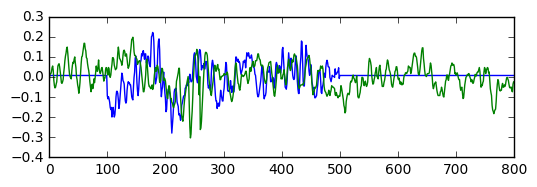

In [19]:
plt.subplot(211)
plt.plot(train_dataset[1,0,:,0])
plt.plot(train_dataset[3,0,:,0])

#### Quantize signal

Based on wavenet paper, raw signal is first mu-law transformed and then quantized to 256 possible values

In [20]:
quantization_levels = 256

def quantize_data(data, levels):
    levels -= 1
    # mu law companding transformation
    data = np.sign(data) * (np.log(1.0 + levels * np.absolute(data)) / np.log(1.0 + levels))
    data = normalize_array(data)
    ## Quantization to int: [(make data > 0) * levels] -> cast uin8
    #data += np.absolute(np.amin(data, axis=0))
    #data /= np.amax(data, axis=0)
    #data = (data*levels).astype(np.int32)
    return data

train_dataset = quantize_data(train_dataset, quantization_levels)
valid_dataset = quantize_data(valid_dataset, quantization_levels)

print('train_dataset shape:', train_dataset.shape)
print('valid_dataset shape:', valid_dataset.shape)

train_dataset shape: (5697, 1, 800, 16)
valid_dataset shape: (200, 1, 800, 16)


#### Plot data after quantization

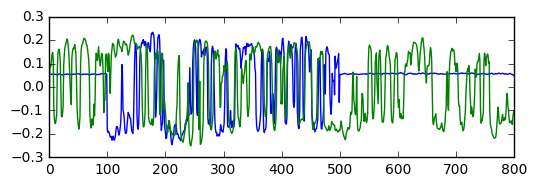

In [21]:
plt.subplot(211)
plt.plot(train_dataset[1,0,:,0])
plt.plot(train_dataset[3,0,:,0])

## EEGNET implementation

Ideas
  - Condition classification based on sensor?
  
Part of https://arxiv.org/pdf/1609.03499.pdf that most concerns classification:
"As a last experiment we looked at speech recognition with WaveNets on the TIMIT (Garofolo et al., 1993) dataset. For this task we added a mean-pooling layer after the dilation convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160 x downsampling). The pooling layer was followed by a few non-causal convolutions. We trained WaveNet with two loss terms, one to predict the next sample and one to classify the frame, the model generalized better than with a single loss and achieved 18.8 PER on the test set, which is to our knowledge the best score obtained from a model trained directly on raw audio on TIMIT."

Look into: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43290.pdf
"Input: This layer extracts 275 ms waveform segments from each of M input microphones. Successive inputs are hopped by 10ms. At the 16kHz sampling rate used in our experiments each segment contains M X 4401 dimensions."
....

In [27]:
#How many files are supplied per batch.
batch_size=16
#Number of samples in each batch entry
batch_samples=train_dataset.shape[2]
#How many filters to learn for the input.
input_channels=16
#How many filters to learn for the gated activation units.
gated_channels=2*input_channels
#How many filters to learn for the residual.
residual_channels=2*input_channels
# size after pooling layer
pool_size = 600
#number of steps after which learning rate is decayed
decay_steps=100

filter_width=5

slim = tf.contrib.slim

#Construct computation graph
graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 1, batch_samples, input_channels))
    tf_train_labels = tf.placeholder(tf.uint8, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float32)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.float32)
    
    def accuracy(logits, labels):
        return tf.div(
            tf.mul(
                tf.to_float(
                tf.reduce_sum(tf.to_int32(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))))
                ), 
                100), 
                tf.to_float(tf.shape(logits)[0]))
    
    def network(batch_data, reuse=False, is_training=True):
        with tf.variable_scope('eegnet_network', reuse=reuse):
            with slim.arg_scope([slim.batch_norm], 
                                is_training=is_training):
                with slim.arg_scope([slim.conv2d, slim.fully_connected], 
                                    weights_initializer=slim.xavier_initializer(), 
                                    normalizer_fn=slim.batch_norm):
                    with tf.variable_scope('input_layer'):
                        hidden = slim.conv2d(batch_data, residual_channels, [1, filter_width], 
                                             stride=1, rate=1, scope='conv1')
                        skip = hidden

                    with tf.variable_scope('hidden_layers'):
                        # layer 1
                        layer_input = hidden
                        filtr = slim.conv2d(hidden, gated_channels, [1, filter_width], stride=1, rate=2, 
                                             activation_fn=tf.tanh, scope='filter1')
                        gate = slim.conv2d(hidden, gated_channels, [1, filter_width], stride=1, rate=2, 
                                             activation_fn=tf.sigmoid, scope='gate1')
                        hidden = slim.conv2d(tf.mul(filtr, gate), residual_channels, 1, scope='1x1skip1')
                        #hidden = tf.add(layer_input, hidden) #residual conn
                        skip = tf.add(skip, hidden) #skip conn
                        # layer 2
                        layer_input = hidden
                        filtr = slim.conv2d(hidden, gated_channels, [1, filter_width], stride=1, rate=4, 
                                             activation_fn=tf.tanh, scope='filter2')
                        gate = slim.conv2d(hidden, gated_channels, [1, filter_width], stride=1, rate=4, 
                                             activation_fn=tf.sigmoid, scope='gate2')
                        hidden = slim.conv2d(tf.mul(filtr, gate), residual_channels, 1, scope='1x1skip2')
                        #hidden = tf.add(layer_input, hidden) #residual conn
                        skip = tf.add(skip, hidden) #skip conn
                        
                    with tf.variable_scope('skip_processing'):
                        hidden = slim.conv2d(skip, residual_channels, 1, scope='1x1conv1')
                        
                    #with tf.variable_scope('prediction'):
                    #    predc = slim.conv2d(hidden, quantization_levels, 1, scope='1x1conv1')

                    with tf.variable_scope('classification'):
                        hidden = slim.conv2d(hidden, 4, 1, scope='1x1conv1')
                        hidden = slim.avg_pool2d(hidden, [1, batch_samples*2//pool_size], [1, batch_samples//pool_size])
                        shape = hidden.get_shape().as_list()
                        hidden = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
                        classf = slim.fully_connected(hidden, num_labels, scope='fc1')
        return classf 

    with tf.name_scope('eegnet_handling'):
        with tf.name_scope('network'):
            classification = network(tf_train_dataset)
        with tf.name_scope('classification_loss'):
            loss_class = slim.losses.softmax_cross_entropy(classification, tf_train_labels, scope='classification_loss')
            tf.scalar_summary('classification_loss', loss_class)
        #with tf.name_scope('prediction_loss'):
        #    # remove last predicted point
        #    predictions = tf.slice(predictions, [0, 0, 0, 0], [-1, -1, batch_samples - 1, -1])
        #    predictions = tf.reshape(predictions, [batch_size * (batch_samples - 1), quantization_levels])
        #    # remove first training sample
        #    shift_data = tf.slice(tf_train_dataset, [0, 0, 1, 0], [-1, -1, -1, -1])
        #    shift_data = tf.reshape(shift_data, [batch_size, (batch_samples - 1)])
        #    # quantization to uint8: [(make data > 0) * levels] -> cast uin8
        #    # data += np.absolute(np.amin(data, axis=0))
        #    # data /= np.amax(data, axis=0)
        #    # data = (data*levels).astype(np.uint8)
        #    shift_data = tf.add(shift_data, tf.abs(tf.reduce_min(shift_data, reduction_indices=0)))
        #    shift_data = tf.div(shift_data, tf.reduce_max(shift_data, reduction_indices=0))
        #    shift_data = tf.mul(shift_data, quantization_levels-1)
        #    shift_data = tf.cast(shift_data, tf.int32) #one hot requires integer indices
        #    shift_data = tf.reshape(shift_data, [batch_size * (batch_samples - 1)])
        #    # loss
        #    loss_pred = slim.losses.sparse_softmax_cross_entropy(predictions, shift_data, scope='prediction_loss')
        #    tf.scalar_summary('prediction_loss', loss_pred)
        with tf.name_scope('total_loss'):
            total_loss = slim.losses.get_total_loss(add_regularization_losses=False)
            tf.scalar_summary('total_loss', total_loss)
        with tf.name_scope('optimizer'):
            global_step = tf.Variable(0)
            learning_rate = tf.train.exponential_decay(1e-1, global_step, decay_steps, 0.96, staircase=True)
            #optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(loss, global_step=global_step)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss, global_step=global_step)
            tf.scalar_summary('learning_rate', learning_rate)
        with tf.name_scope('accuracy'):
            train_predictions = tf.nn.softmax(classification)
            valid_predictions = tf.nn.softmax(network(tf_valid_dataset, True, True))
            train_accuracy = accuracy(train_predictions, tf_train_labels)
            valid_accuracy = accuracy(valid_predictions, tf_valid_labels)

    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.histogram_summary(var.op.name, var)
        
    # Add summaries for activations: NOT WORKING YET. TF ERROR.
    #slim.summarize_activations()
    
    #Merge all summaries and write to a folder
    merged = tf.merge_all_summaries()
    results_writer = tf.train.SummaryWriter('./results', graph)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    #tracing for timeline
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()    
    
print('computational graph created')

computational graph created


In [28]:
num_steps = 4001

trace_file = open('./tracing/timeline.json', 'w')
save_path = './checkpoints/model.ckpt'

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    tf.initialize_local_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, tloss, lrate, trpred, traccu, summary = session.run(
            [optimizer, total_loss, learning_rate, train_predictions, train_accuracy, merged], 
            feed_dict=feed_dict, 
            options=run_options,
            run_metadata=run_metadata)
        results_writer.add_summary(summary, step)
        if (step % 15 == 0):
            print('Minibatch total loss at step %d: %f' % (step, tloss), 'Learning rate:', lrate)
            print('Minibatch accuracy:', traccu)
            print('Predictions | Labels:\n', np.concatenate((trpred[:2], batch_labels[:2]), axis=1))
        if (step % 100 == 0):
            print('Validation accuracy:', valid_accuracy.eval())
            
    # Save tracing into disl
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)
    trace_file.write(trace.generate_chrome_trace_format(show_memory=True))
            
    # Save the variables to disk.
    saver.save(session, save_path)
    print("Model saved in file: %s" % save_path)
            
    results_writer.flush()
    results_writer.close()

    print('Finished training')

Initialized
Minibatch total loss at step 0: 0.898003 Learning rate: 0.1
Minibatch accuracy: 31.25
Predictions | Labels:
 [[ 0.46914831  0.53085172  1.          0.        ]
 [ 0.71322298  0.28677696  1.          0.        ]]
Validation accuracy: 42.5
Minibatch total loss at step 15: 0.610924 Learning rate: 0.1
Minibatch accuracy: 75.0
Predictions | Labels:
 [[ 0.5         0.5         1.          0.        ]
 [ 0.25001103  0.74998897  1.          0.        ]]
Minibatch total loss at step 30: 0.634238 Learning rate: 0.1
Minibatch accuracy: 50.0
Predictions | Labels:
 [[ 0.5         0.5         0.          1.        ]
 [ 0.24746716  0.75253278  0.          1.        ]]
Minibatch total loss at step 45: 0.734577 Learning rate: 0.1
Minibatch accuracy: 68.75
Predictions | Labels:
 [[ 0.48864672  0.51135331  0.          1.        ]
 [ 0.4738808   0.52611923  1.          0.        ]]
Minibatch total loss at step 60: 0.751755 Learning rate: 0.1
Minibatch accuracy: 43.75
Predictions | Labels:
 [[ 

## Evaluate Model

In [ ]:
valid_batch_size = 1

def accuracy_notpercent(predictions, labels):
  return np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))

with tf.Session(graph=graph) as session:
    saver.restore(session, save_path)
    print('Model Loaded')
    data_split = np.array_split(valid_dataset, valid_dataset.shape[0]//valid_batch_size, axis=0)
    labels_split = np.array_split(valid_labels, valid_labels.shape[0]//valid_batch_size, axis=0)
    correct_predictions = 0
    for idx, batch_data in enumerate(data_split):
        correct_predictions += accuracy_notpercent(
            train_prediction.eval(feed_dict={tf_train_dataset: batch_data}), 
            labels_split[idx])
        print('accuracy:', (100.0*correct_predictions)/((idx+1)*valid_batch_size))
        
        
    print('Finished validation')